This notebook shows an example of looking at the amount of signal accumulated over multiple scans (a.k.a. "Depths"). It uses the MIBItiff files outputted for each scan which are available in MIBI/O >= v1.5.3. It is recommended to select one or more channels to use for alignment when processing multi-scan FOVs.

In [2]:
import os
import re
import sys

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd

sys.path.append('..')
from mibidata import tiff, util

%matplotlib notebook

matplotlib.rcParams.update({
    'font.size': 8,
    'axes.grid': False,
})

In [3]:
# The fov_path is defined to the local data folder and assumes that TIFFs have been created with MIBI/O.
def get_scan_tiffs(fov_path):
    depths = [d for d in os.listdir(fov_path) if re.match('Depth[0-9]+', d)]
    util.natural_sort(depths)
    return depths, [tiff.read(os.path.join(fov_path, depth, '{}.tiff'.format(depth))) for depth in depths]

In [4]:
depths, images = get_scan_tiffs('<path>/<to>/<point>/RowNumber0/Depth_Profile0')
num_depths = len(images)
print(images[0].targets)

('beta-tubulin', 'CD11c', 'CD3', 'CD31', 'CD4', 'CD45', 'CD56', 'CD68', 'CD8', 'dsDNA', 'FOXP3', 'HLA class 1 A, B, and C', 'Keratin', 'Lamin A-C', 'Na-K-ATPase alpha1', 'PD-L1', 'Vimentin')


In [5]:
ticks = [0] + [2**i for i in range(0, 9)]

def scale(channel):
    channel_max = channel.max(axis=(0, 1))
    scaled = np.power(channel / channel_max, 1/2)
    ticklocs = np.power(ticks / channel_max, 1/2)
    return scaled, ticklocs

def plot_channel_depths(target):
    fig, ax = plt.subplots(num_depths, 2, figsize=(8, 4*num_depths), sharex=True, sharey=True)
    cumulative = np.zeros_like(images[0].data[:, :, 0])
    for i, depth in enumerate(depths):
        channel_data = images[i][target]
        scaled, ticklocs = scale(channel_data)
        im = ax[i, 0].imshow(scaled)
        divider = make_axes_locatable(ax[i, 0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_ticks(ticklocs)
        cb.set_ticklabels(ticks)
        
        cumulative += channel_data
        scaled, ticklocs = scale(cumulative)
        im = ax[i, 1].imshow(scaled)
        divider = make_axes_locatable(ax[i, 1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_ticks(ticklocs)
        cb.set_ticklabels(ticks)
        
        ax[i, 0].axis('off')
        ax[i, 0].set_title('{} {}'.format(target, depth))
        ax[i, 1].axis('off')
        ax[i, 1].set_title('{} Cumulative through {}'.format(target, depth))
    fig.tight_layout()

The functions here set the white level in each image to its max and display at gamma=1/2, adding a colorbar to denote the range of the original pixel counts.

<IPython.core.display.Javascript object>


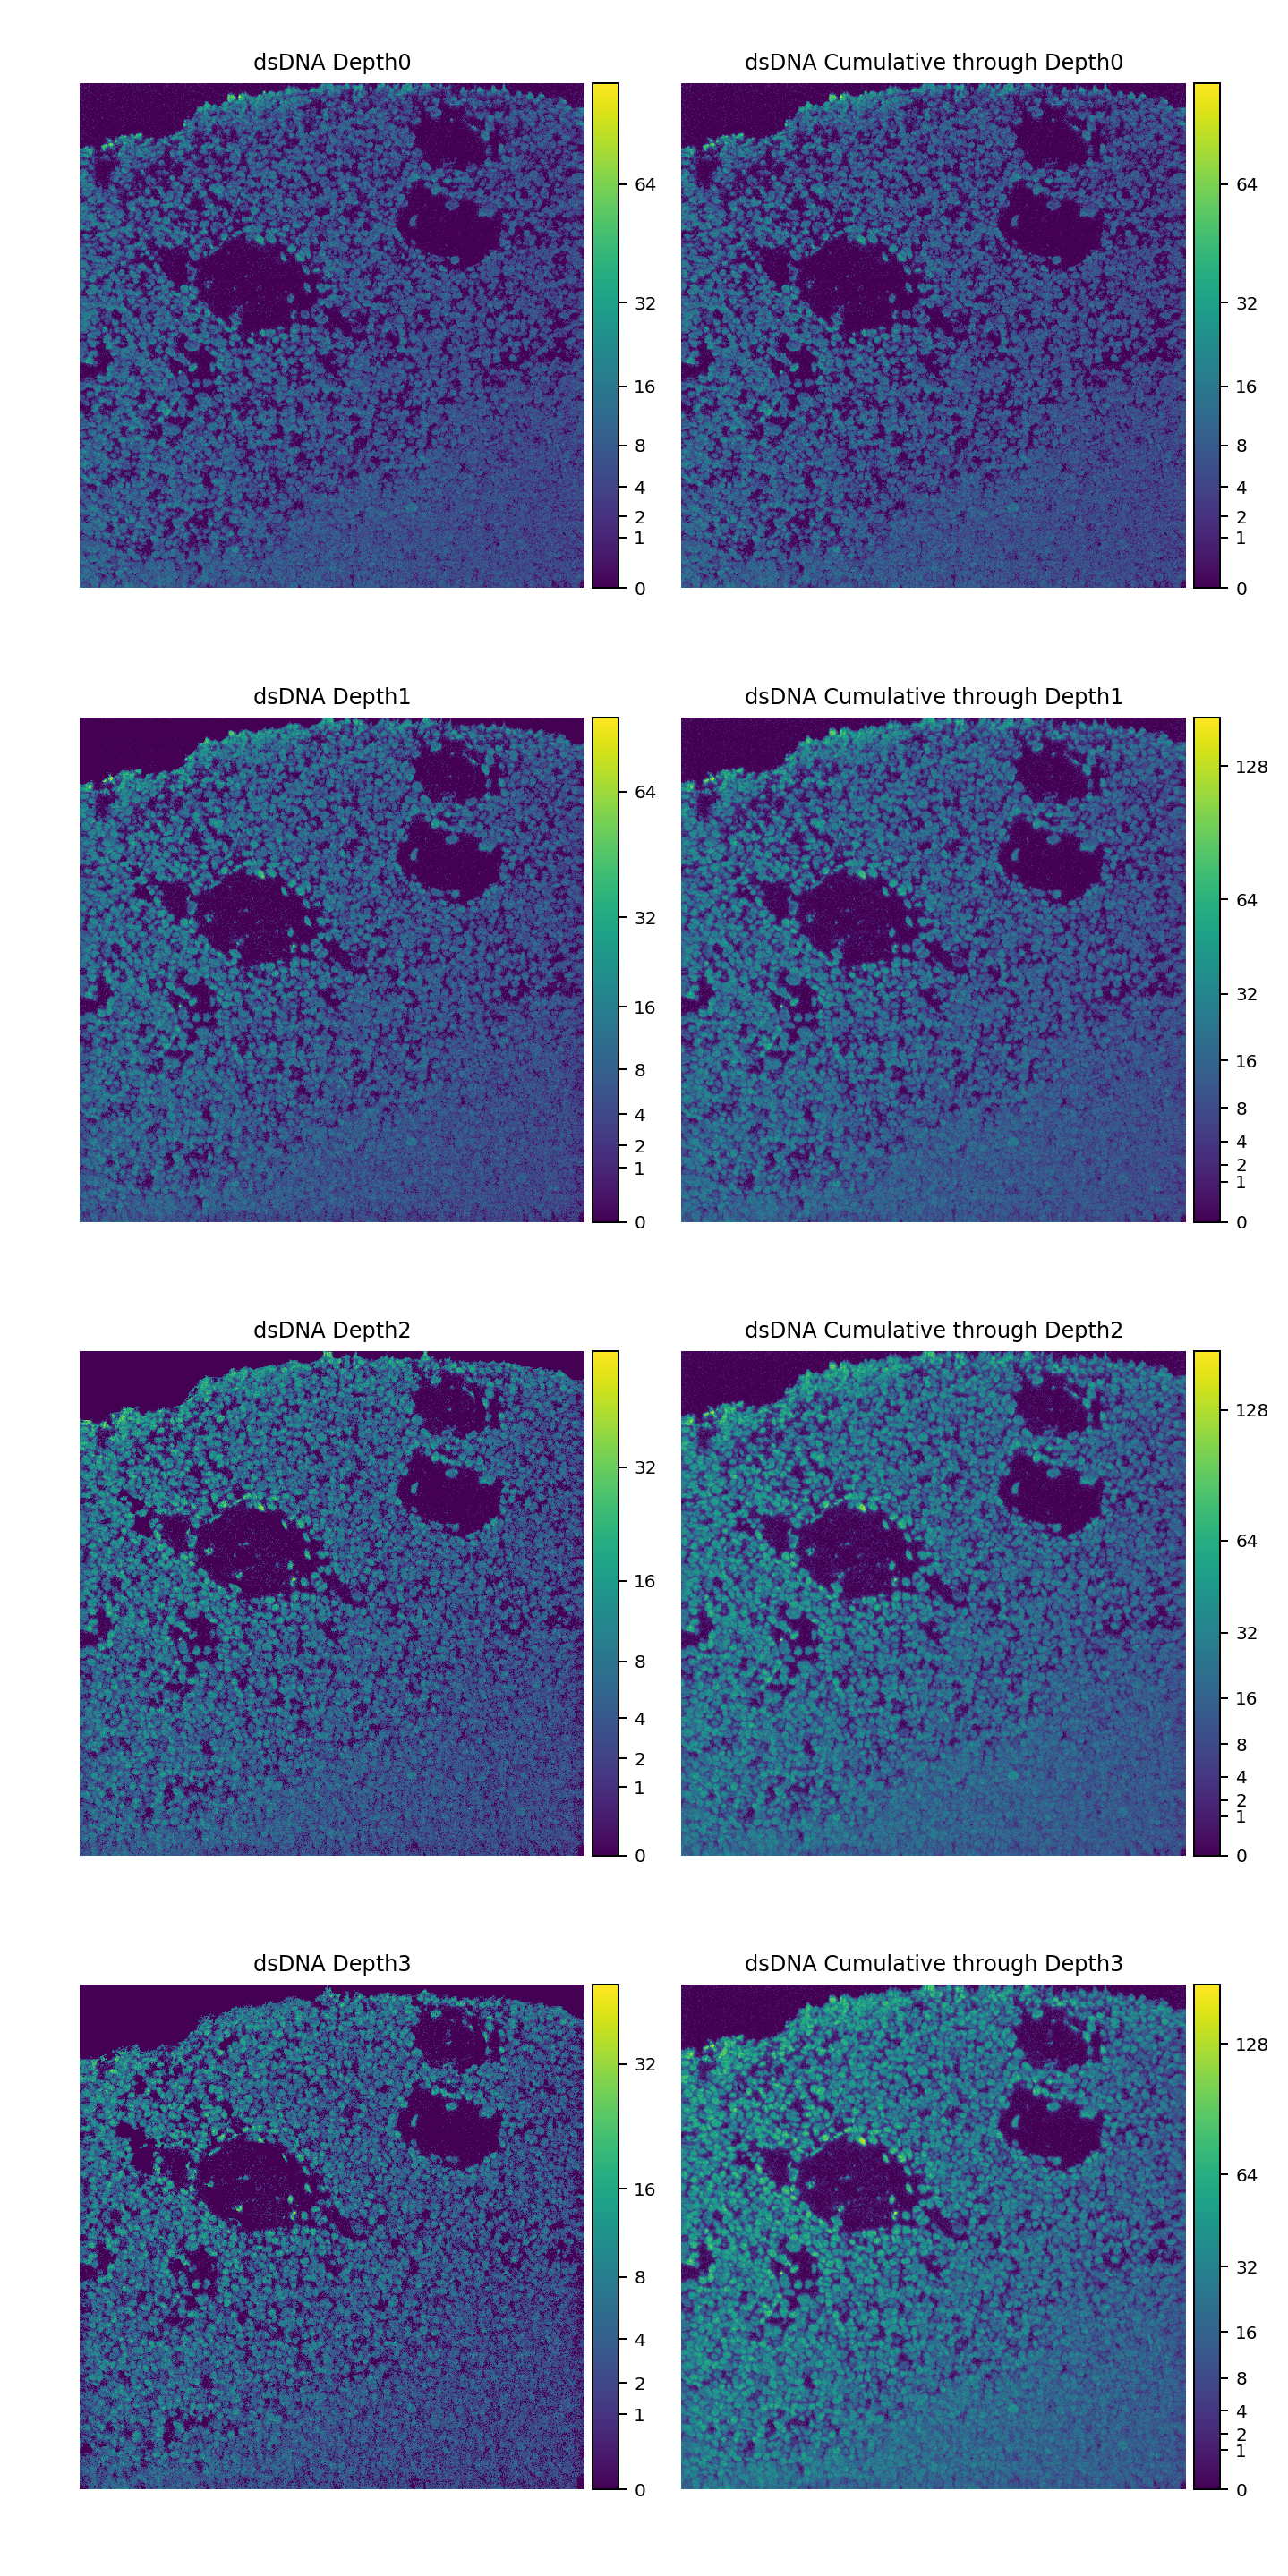

In [6]:
plot_channel_depths('dsDNA')

<IPython.core.display.Javascript object>


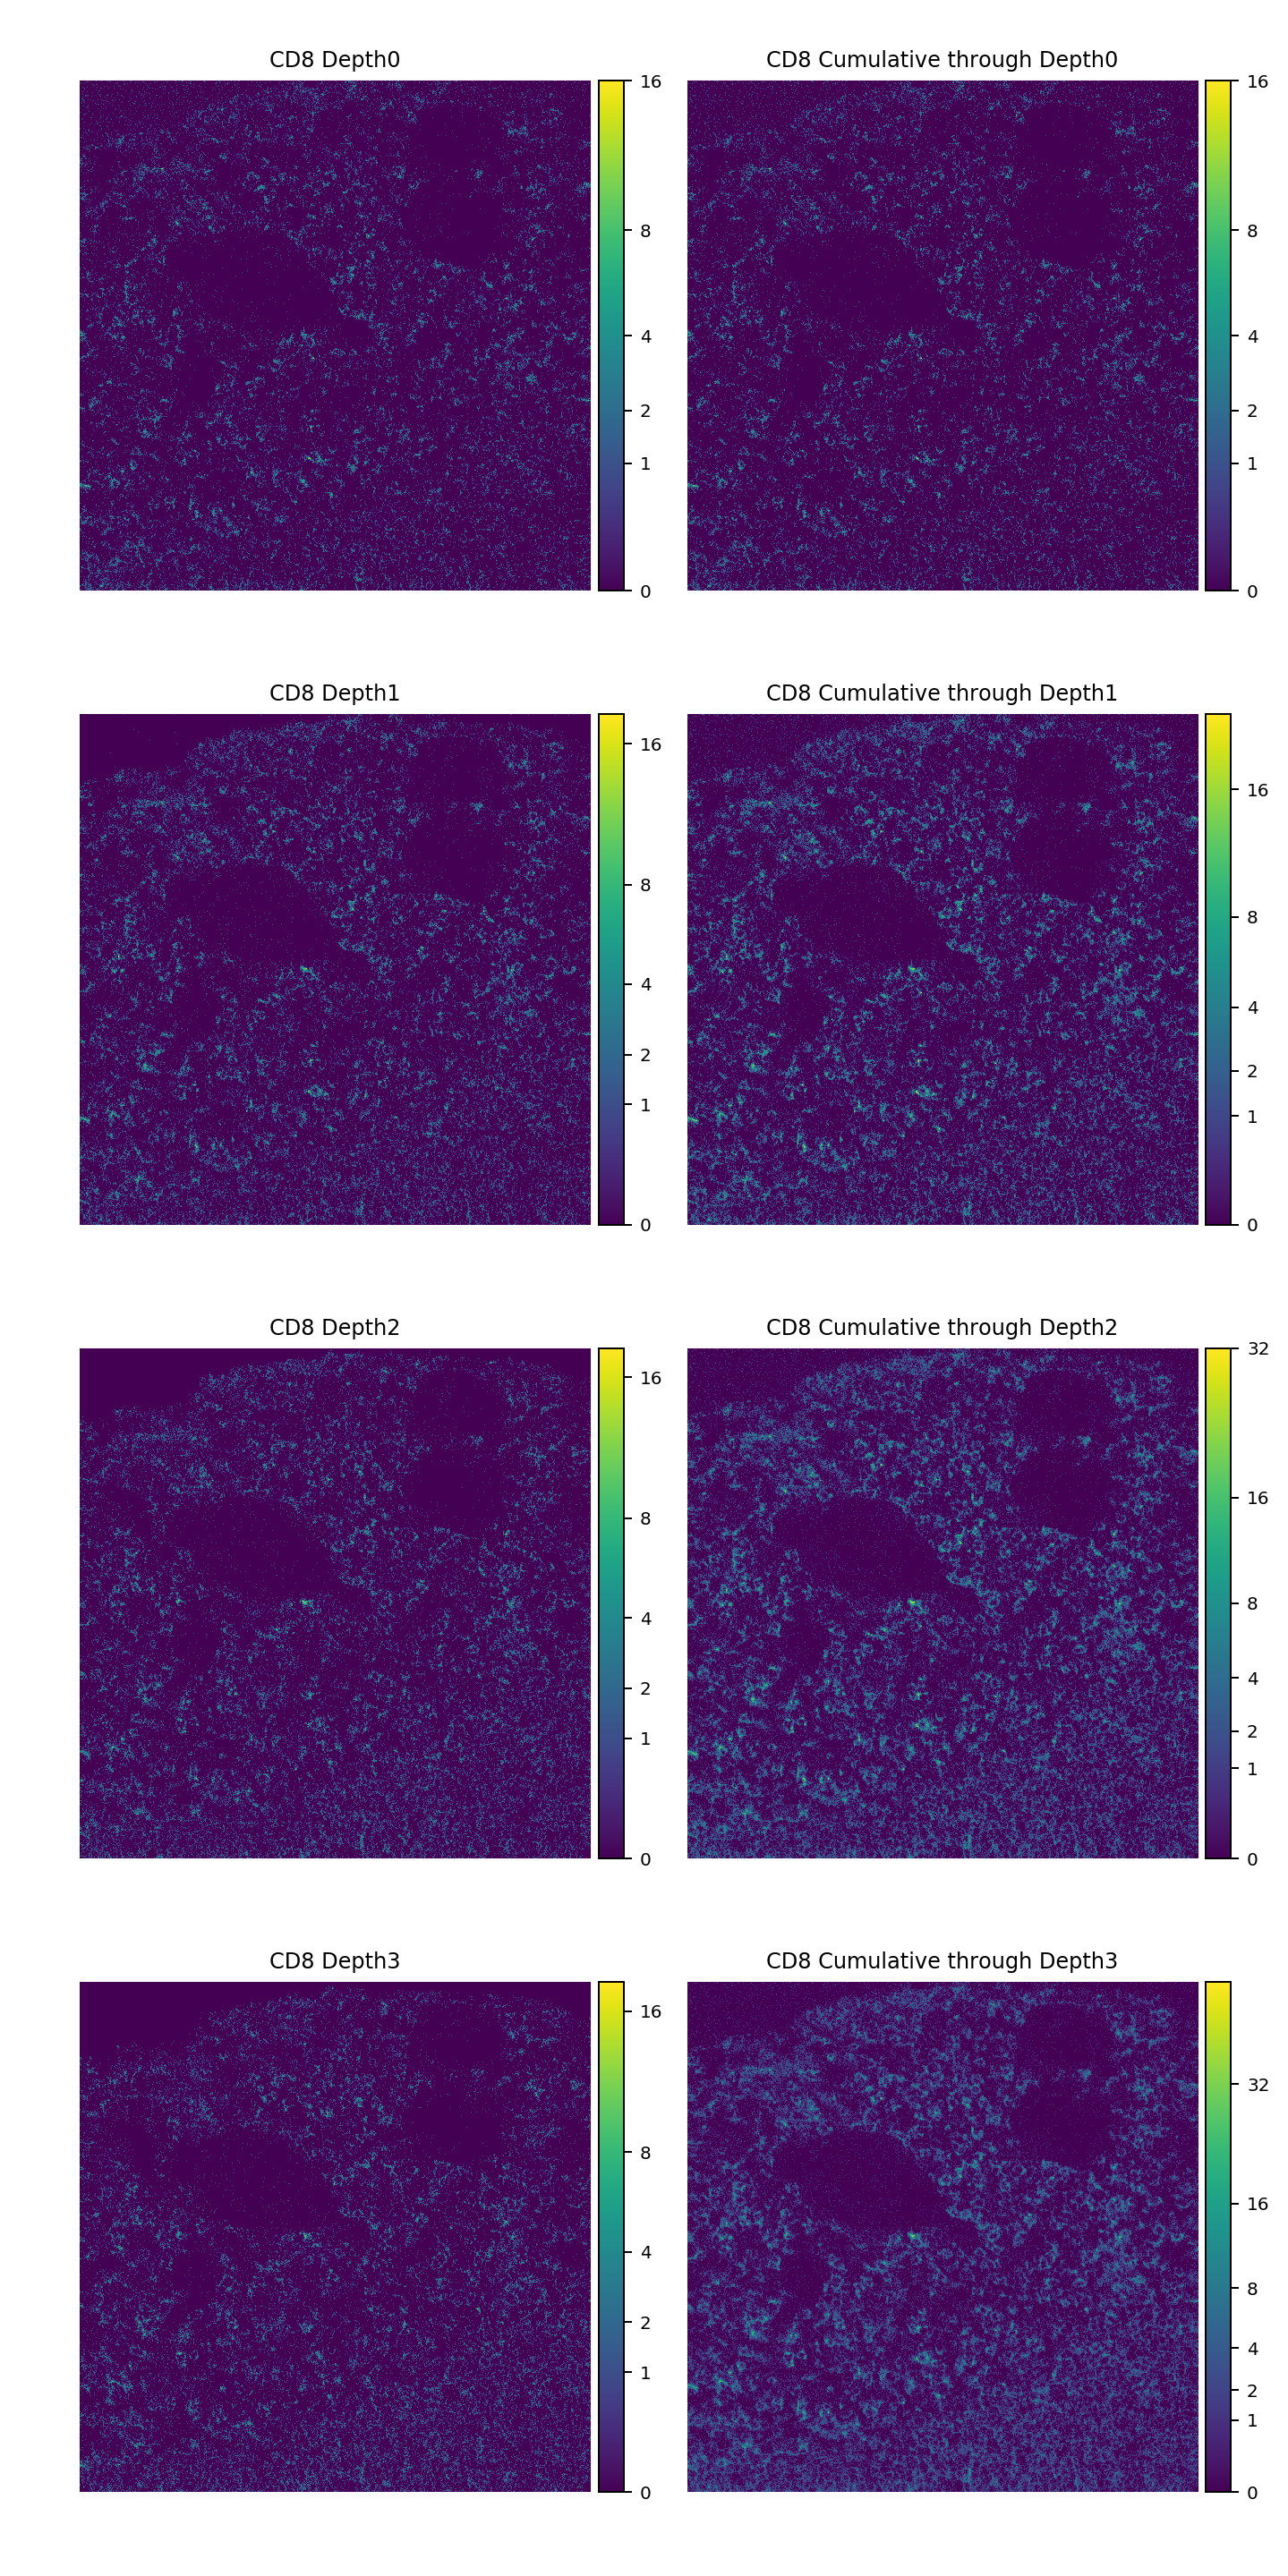

In [7]:
plot_channel_depths('CD8')

Plotting total counts of all channels across scans gives a quantitative overview.

In [8]:
total_counts = {}
for i, depth in enumerate(depths):
    total_counts[depth] = images[i].data.sum(axis=(0, 1))
df = pd.DataFrame(total_counts, index=images[0].targets)
df

Depth0   Depth1   Depth2   Depth3
beta-tubulin             1912194  2753544  2536470  2367549
CD11c                      45463    60534    55984    54310
CD3                       566891   812986   728521   672291
CD31                       59729    89668    84830    82210
CD4                       164564   238074   215422   200254
CD45                     1076507  1492553  1344299  1255979
CD56                       18184    24646    22914    22223
CD68                       27361    41346    39900    39675
CD8                       178467   262773   243630   227259
dsDNA                    5659098  6221980  4582437  3481425
FOXP3                      54989    73396    62161    56350
HLA class 1 A, B, and C   996819  1484782  1353175  1230737
Keratin                   271244   448563   460437   473085
Lamin A-C                  91543   148598   147975   143266
Na-K-ATPase alpha1        229168   345510   330029   323743
PD-L1                      37683    54080    50447    47538
Vimentin                  499987   831508   833474   818627

<IPython.core.display.Javascript object>


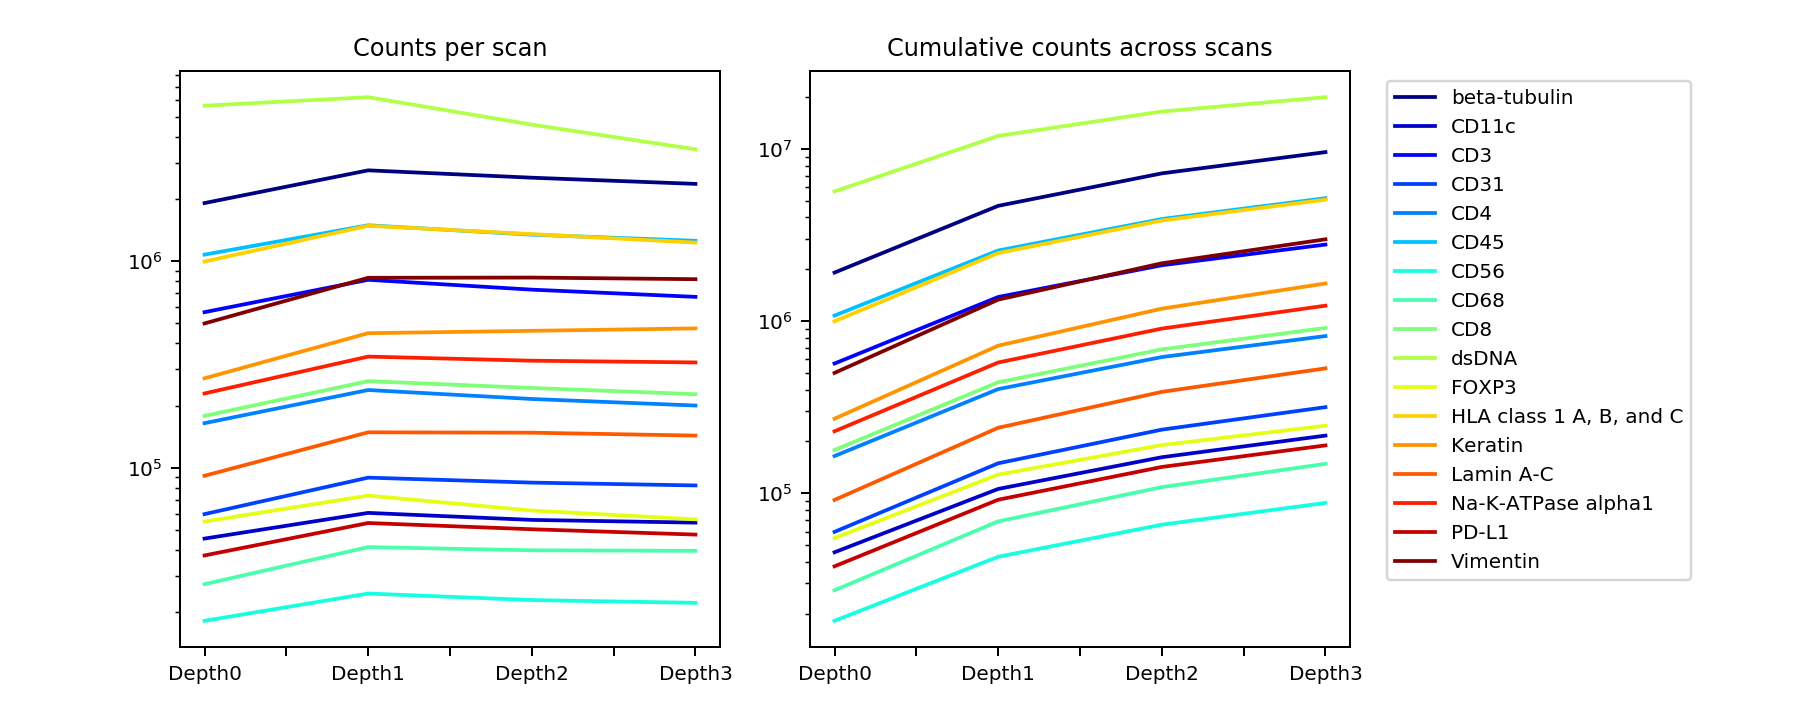

In [9]:
fig = plt.figure(figsize=(10, 4))
ax0 = fig.add_axes([0.1, 0.1, 0.3, 0.8])
df.T.plot(ax=ax0, logy=True, cmap='jet', legend=None)
ax0.set_title('Counts per scan')
ax1 = fig.add_axes([0.45, 0.1, 0.3, 0.8])
df.T.cumsum().plot(ax=ax1, logy=True, cmap='jet')
ax1.set_title('Cumulative counts across scans')
_ = ax1.legend(bbox_to_anchor=(1.05, 1), loc=2)

One can also plot counts for specified ROIs.

<IPython.core.display.Javascript object>


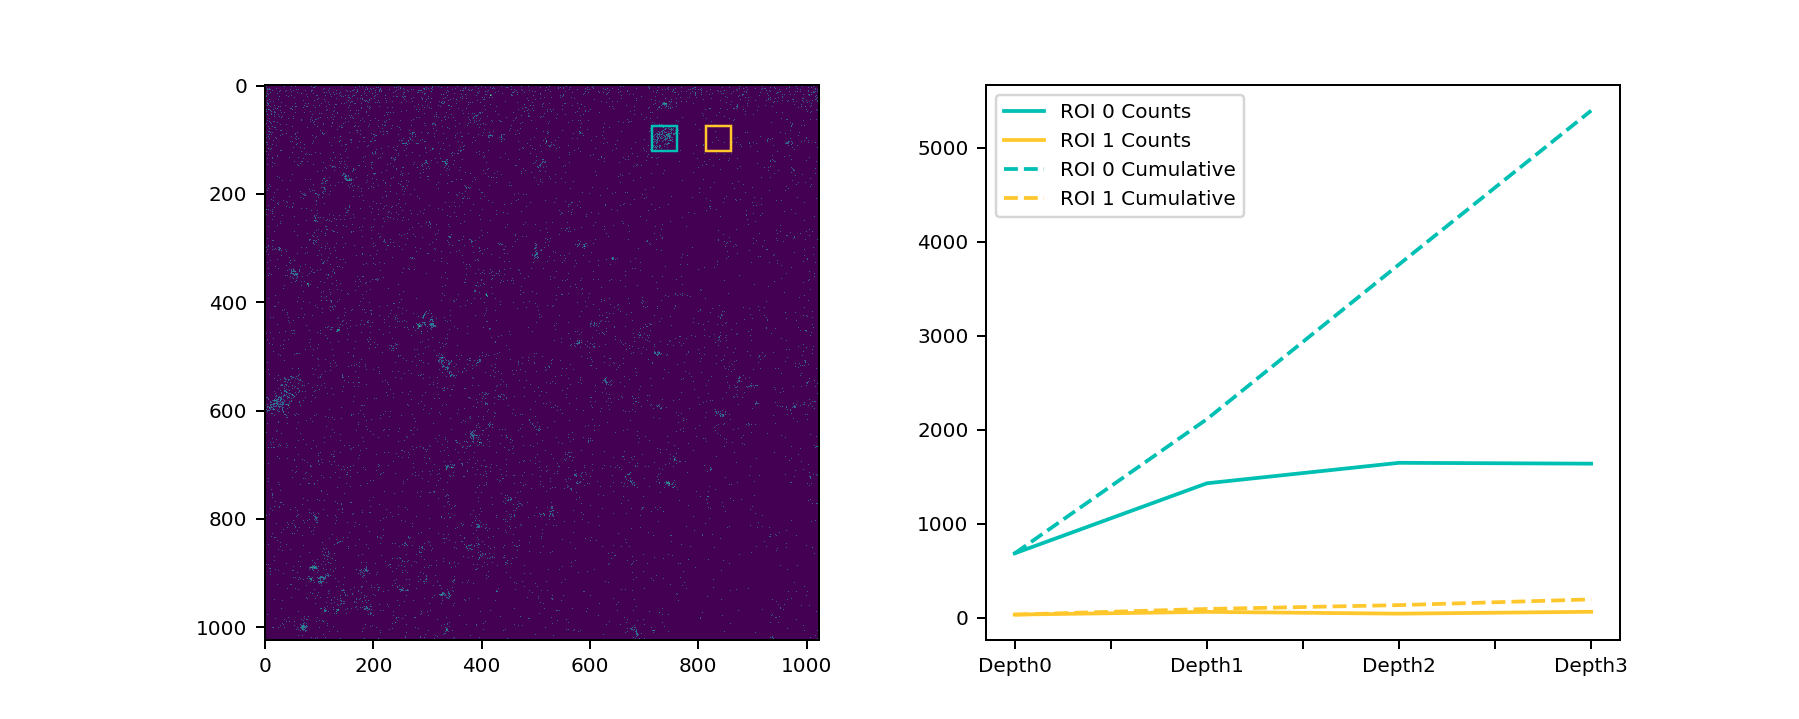

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

cm = matplotlib.colors.ListedColormap(['#00bfb3', '#ffc72c'])

scaled, _ = scale(images[0]['CD68'])
xstart = 715
xstop = 760
ystart = 75
ystop = 120
ax[0].imshow(scaled)
rect0 = patches.Rectangle((xstart, ystart), ystop-ystart, xstop-xstart,
                          linewidth=1, edgecolor=cm.colors[0], facecolor='none')
# Make a second ROI shifted to the right, away from the area of brighter signal.
rect1 = patches.Rectangle((xstart + 100, ystart), ystop-ystart, xstop-xstart,
                          linewidth=1, edgecolor=cm.colors[1], facecolor='none')
ax[0].add_patch(rect0)
ax[0].add_patch(rect1)

roi0_counts = []
roi1_counts = []
for i, depth in enumerate(depths):
    roi0_counts.append(images[i]['CD68'][ystart:ystop, xstart:xstop].sum(axis=(0, 1)))
    roi1_counts.append(images[i]['CD68'][ystart:ystop, xstart+100:xstop+100].sum(axis=(0, 1)))
df = pd.DataFrame({'ROI 0': roi0_counts, 'ROI 1': roi1_counts}, index=depths)
df.plot(ax=ax[1], cmap=cm)
df.cumsum().plot(ax=ax[1], linestyle='--', cmap=cm)
ax[1].legend(['ROI 0 Counts', 'ROI 1 Counts', 'ROI 0 Cumulative', 'ROI 1 Cumulative'])